Import all the necessary libraries


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
import numpy as np
import PIL.Image as Image


Load and Preprocess Image

In [43]:
def preprocess_image(image_path, img_height, img_width):
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


Deprocess (Convert Tensor back to Image)

In [45]:
def deprocess_image(x):
    x = x.numpy()
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Content Loss

In [47]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


In [49]:
def gram_matrix(x):
    x = tf.squeeze(x)  # Remove batch dimension -> [height, width, channels]
    x = tf.reshape(x, (-1, x.shape[-1]))  # Reshape to [height * width, channels]
    gram = tf.matmul(x, x, transpose_a=True)  # Gram Matrix
    return gram



Style Loss

In [51]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)

    channels = int(style.shape[-1])
    size = int(style.shape[1] * style.shape[2])

    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))



Load Images

In [53]:
img_height = 400
img_width = 400

content_image_path = 'profile.jpeg'
style_image_path = 'dali.jpeg'

content_image = preprocess_image(content_image_path, img_height, img_width)
style_image = preprocess_image(style_image_path, img_height, img_width)
combination_image = tf.Variable(preprocess_image(content_image_path, img_height, img_width))


Load Pre-trained VGG19 Model

In [55]:
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.input, outputs=outputs_dict)


Select Layers

In [57]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


Define Weights for Loss

In [59]:
content_weight = 1e3
style_weight = 50     



Compute Total Loss Function

In [61]:
def compute_loss():
    content_features = feature_extractor(content_image)
    style_features = feature_extractor(style_image)
    combination_features = feature_extractor(combination_image)

    loss = tf.zeros(shape=())

    target_content = content_features[content_layer]
    combination_content = combination_features[content_layer]

    loss += content_weight * content_loss(target_content, combination_content)

    for layer_name in style_layers:
        style_feature = style_features[layer_name]
        combination_feature = combination_features[layer_name]
        loss += (style_weight / len(style_layers)) * style_loss(style_feature, combination_feature)

    return loss


Optimizer and Training Step

In [63]:
opt = tf.optimizers.Adam(learning_rate=5.0)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss()
    grads = tape.gradient(loss, combination_image)
    opt.apply_gradients([(grads, combination_image)])
    combination_image.assign(tf.clip_by_value(combination_image, -128.0, 128.0))


Train the Model

In [75]:
epochs = 250

for i in range(epochs):
    train_step()
    if i % 50 == 0:
        print("Iteration:", i)


Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200


 Save Final Output Image

In [77]:
final_img = deprocess_image(combination_image)
Image.fromarray(final_img).save('final_output.png')


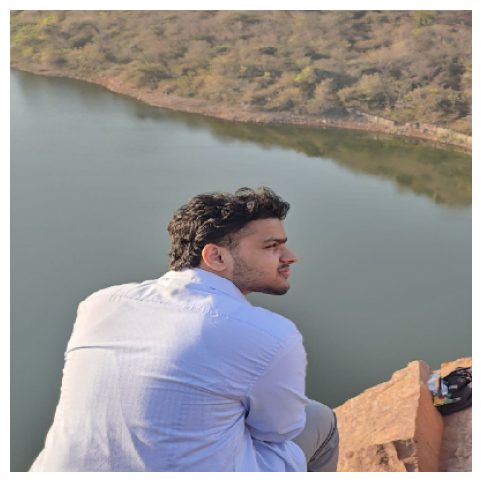

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Load image and resize
image = load_img(content_image_path, target_size=(img_height, img_width))
image = img_to_array(image) / 255.0  # Normalize to [0,1] range

# Display Image
plt.figure(figsize=(6,6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()


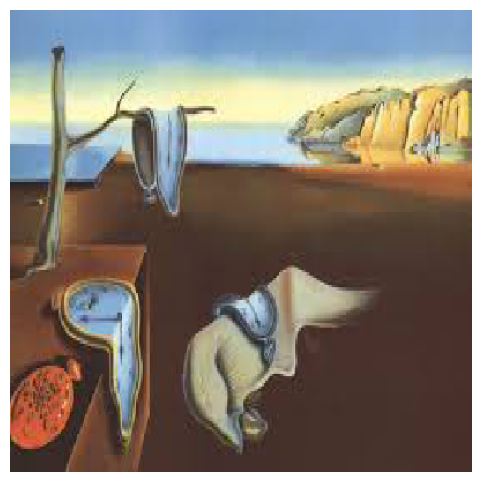

In [81]:
image = load_img(style_image_path, target_size=(img_height, img_width))
image = img_to_array(image) / 255.0  # Normalize to [0,1] range

# Display Image
plt.figure(figsize=(6,6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

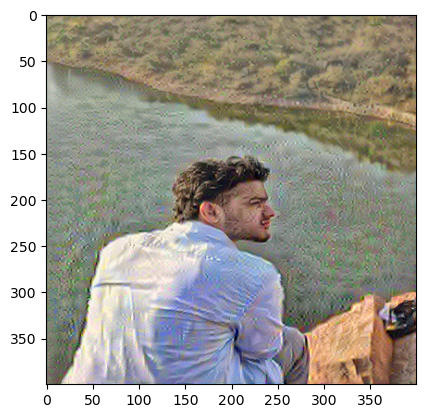

In [83]:
from matplotlib import pyplot as plt
plt.imshow(final_img)
plt.show()
